In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
import os, glob

from utilities import downsample_series

In [ ]:
%matplotlib inline

In [5]:
# %% Need to specify model_name first
model_path = './Model_and_datasets_spectrogram'
model_name = 'spectrogram_mask_skip_connection'

# %% load model
model = keras.models.load_model(model_path + f'/{model_name}' + f'/{model_name}_Model.hdf5')

# %% make a directory to hold the realistic waveform results
output_dir = model_path + f'/{model_name}' + '/real_waveforms'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [38]:
def load_waveform_and_spectrogram(waveform_dir, file_name, t_shift):
    with h5py.File(waveform_dir + "/" + file_name, "r") as f:
        time = f["time"][:]
        waveform_BH1 = f["waveforms/BH1"][:]
        waveform_BH2 = f["waveforms/BH2"][:]
        waveform_BHZ = f["waveforms/BHZ"][:]
        
    # down-sample the data to the same sampling rate with the trained model
    waveforms, spectrograms, spectrogram_para = [], [], {}
    f_downsample = 1.0
    dt = 1 / f_downsample
    for waveform in [waveform_BH1, waveform_BH2, waveform_BHZ]:
        _, waveform_cur, _ = downsample_series(time=time, 
                                                   series=waveform, 
                                                   f_downsampe=f_downsample)
        time_new = np.arange(0, 600) + t_shift
        waveform_cur = waveform_cur[time_new]
        
        
        
        # STFT the waveforms
        twin = 30
        toverlap = 11  # chose 11 here to make a better shape of the spectrogram
        win_type = 'hann'

        f, t, Sxx_X = waveform_stft(waveform_cur, 
                                    dt, twin=twin, toverlap=toverlap, 
                                    win_type=win_type, complex=True)
        
        # extract and scale each part
        X_real = np.real(Sxx_X)
        X_imag = np.imag(Sxx_X)
        
        mean_real, std_real = np.mean(X_real.flatten()), np.std(X_real.flatten())
        mean_imag, std_imag = np.mean(X_imag.flatten()), np.std(X_imag.flatten())
        X_real = (X_real - mean_real)/ std_real
        X_imag = (X_imag - mean_imag)/ std_imag
        
        # append the processed waveforms and spectrograms
        waveforms.append(waveform_cur)
        spectrograms.append(X_real)
        spectrograms.append(X_imag)
        
    # store some parameters about the spectrogram    
    spectrogram_para['dt'] = dt
    spectrogram_para['twin'] = twin
    spectrogram_para['win_type'] = win_type
    spectrogram_para['toverlap'] = toverlap
    spectrogram_para['t'] = t
    spectrogram_para['f'] = f
    
    waveforms = np.array(waveforms)
    spectrograms = np.array(spectrograms)
    
    return time_new, waveforms, spectrograms, spectrogram_para

In [7]:
# load the waveforms
waveform_dir = "./waveforms/events_data_processed"
waveform_files = np.array(os.listdir(waveform_dir))

In [39]:
file_name = "IU.XMAS.M6.0.20191224-190352.hdf5"
t_shift = 0
time_new, waveforms, spectrograms, spectrogram_para = load_waveform_and_spectrogram(waveform_dir, file_name, t_shift)

In [44]:
spectrogram_para


{'dt': 1.0,
 'twin': 30,
 'win_type': 'hann',
 'toverlap': 11,
 't': array([  0.,  19.,  38.,  57.,  76.,  95., 114., 133., 152., 171., 190.,
        209., 228., 247., 266., 285., 304., 323., 342., 361., 380., 399.,
        418., 437., 456., 475., 494., 513., 532., 551., 570., 589., 608.]),
 'f': array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       ])}

In [9]:
waveforms_new.shape

(1, 600, 3)

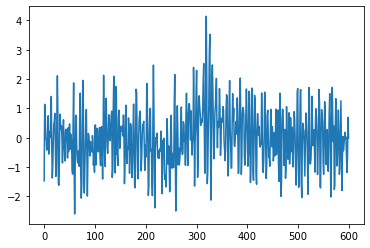

In [10]:
plt.plot(time_new, np.squeeze(waveforms_new[0, :, 0]))

In [11]:
from utilities import waveform_stft, waveform_inverse_stft